In [1]:
import os

import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

2024-12-10 13:11:46.198009: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Config

In [2]:
# used top-20000 frequent words
vocab_size = 20000

# restrict the length of document to 200
maxlen = 200

# model path
base_model_dir = "../model"
os.makedirs(base_model_dir, exist_ok=True)

ckpt_path = os.path.join(base_model_dir, "transformer_sentiment", "ckpt")

## Load Dataset

In [3]:
(X_train_raw, y_train_raw), (X_test_raw, y_test_raw) = imdb.load_data(num_words=vocab_size)
word_to_idx = imdb.get_word_index()
idx_to_word = {v: k for k, v in word_to_idx.items()}

In [4]:
print(f"num train: {len(X_train_raw)}")
print(f"num test: {len(X_test_raw)}")

num train: 25000
num test: 25000


Text(0, 0.5, 'Frequency')

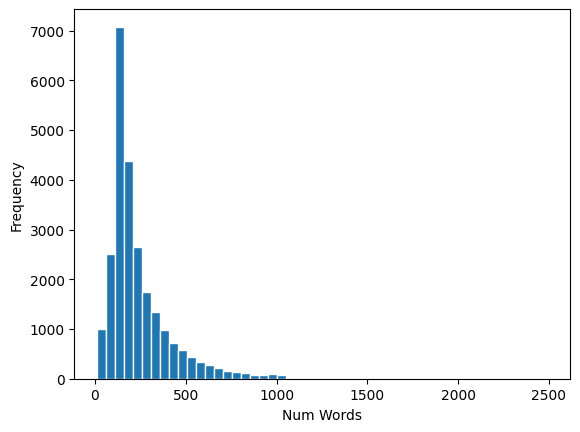

In [5]:
num_train_words = list(map(len, X_train_raw))

fig, ax = plt.subplots(1, 1)
ax.hist(num_train_words, bins=50, edgecolor="white")
ax.set_xlabel("Num Words")
ax.set_ylabel("Frequency")

## Preproess Dataset

In [6]:
# train/valid split
X_train_raw, X_valid_raw, y_train_raw, y_valid_raw = train_test_split(X_train_raw, y_train_raw, random_state=1234)

In [7]:
# restrict the length of document

X_train = sequence.pad_sequences(X_train_raw, maxlen=maxlen)
X_valid = sequence.pad_sequences(X_valid_raw, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test_raw, maxlen=maxlen)

y_train = to_categorical(y_train_raw)
y_valid = to_categorical(y_valid_raw)
y_test = to_categorical(y_test_raw)

In [8]:
X_train.shape, X_valid.shape, X_test.shape

((18750, 200), (6250, 200), (25000, 200))

In [9]:
len(X_train_raw[0]), len(X_train[0])

(218, 200)

In [10]:
# note that pad_sequences select last maxlen words
X_train_raw[0][-200:] == X_train[0]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

## Build Model

In [11]:
class EncoderBlock(layers.Layer):
    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        ff_dim: int,
        rate: float = 0.1,
    ) -> None:
        super().__init__()

        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layers_norm1 = layers.LayerNormalization()
        self.layers_norm2 = layers.LayerNormalization()
        self.droupout1 = layers.Dropout(rate)
        self.droupout2 = layers.Dropout(rate)

    def call(
        self,
        inputs: tf.Tensor,
        training: bool,
    ) -> tf.Tensor:
        # attention
        att_out = self.att(inputs, inputs)
        att_out = self.droupout1(att_out, training=training)
        # residual connection (add+norm)
        out = self.layers_norm1(inputs + att_out)
        # feedforward
        ffn_out = self.ffn(out)
        ffn_out = self.droupout2(ffn_out, training=training)
        # residual connection (add+norm)
        return self.layers_norm2(out + ffn_out)

In [12]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(
        self,
        maxlen: int,
        vocab_size: int,
        embed_dim: int,
    ) -> None:
        super().__init__()

        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        # train position embedding vector here
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(
        self,
        x: tf.Tensor,
    ) -> tf.Tensor:
        maxlen = tf.shape(x)[1]
        pos = tf.range(0, limit=maxlen, delta=1)
        pos = self.pos_emb(pos)
        x = self.token_emb(x)
        return x + pos

In [13]:
def build_model(    
    maxlen: int,
    vocab_size: int,
    embed_dim: int = 32,
    num_heads: int = 2,
    ff_dim: int = 32,
    rate: float = 0.1
) -> Model:
    inputs = layers.Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(
        maxlen=maxlen,
        vocab_size=vocab_size,
        embed_dim=embed_dim
    )
    x = embedding_layer(inputs)
    x = EncoderBlock(embed_dim, num_heads, ff_dim)(x)
    x = EncoderBlock(embed_dim, num_heads, ff_dim)(x)
    x = layers.GlobalAvgPool1D()(x)
    x = layers.Dropout(rate)(x)
    x = layers.Dense(20, activation="relu")(x)
    x = layers.Dropout(rate)(x)
    outputs = layers.Dense(2, activation="softmax")(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [14]:
embed_dim = 32
num_heads = 2
ff_dim = 32

In [15]:
model = build_model(maxlen=maxlen, vocab_size=vocab_size)

2024-12-10 13:11:51.864372: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-10 13:11:51.866699: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-10 13:11:51.866848: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-10 13:11:51.867190: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [16]:
# embedding params: 64600
#   - vocab_size*embed_dim + input_length*embed_dim
#   - (20000*32) + (200*32) = 640000 + 6400 = 646400
# encoder block params: 10656
#   - attention params + layer norm params + ff params + ff params + layer norm params
#   - ((32*32*3 + 32*3)*2 + (32*2*32 + 32)) + (32*2) + (32*32 + 32) + (32*32 + 32) + (32*2) = 8416 + 64 + 1056 + 1056 + 64
#      - (32*32*3 + 32*3)*2 ((embed_dim*key_dim*(Q,K,V) + bias_key_dim*(Q,K,V)))*num_heads
#      - (32*2*32 + 32): output projection (64 -> 32)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 token_and_position_embeddin  (None, 200, 32)          646400    
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 encoder_block (EncoderBlock  (None, 200, 32)          10656     
 )                                                               
                                                                 
 encoder_block_1 (EncoderBlo  (None, 200, 32)          10656     
 ck)                                                             
                                                                 
 global_average_pooling1d (G  (None, 32)               0     

In [17]:
model.compile(
    optimizer=Adam(1e-3),
    loss="binary_crossentropy",
    metrics="accuracy"
)

In [18]:
es_cb = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)
ckpt_cb = ModelCheckpoint(
    filepath=ckpt_path,
    monitor="val_loss",
    mode="min",
    save_weights_only=True,
    save_best_only=True
)

In [19]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs=50,
    batch_size=512,
    callbacks=[es_cb, ckpt_cb],
)

Epoch 1/50


2024-12-10 13:11:56.638960: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-12-10 13:11:56.795285: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fd0896c0ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-10 13:11:56.795326: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2024-12-10 13:11:56.832851: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-10 13:11:57.206418: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


37/37 [==============================] - 13s 169ms/step - loss: 0.6406 - accuracy: 0.6378 - val_loss: 0.4458 - val_accuracy: 0.8171
Epoch 2/50
37/37 [==============================] - 6s 153ms/step - loss: 0.3418 - accuracy: 0.8609 - val_loss: 0.3437 - val_accuracy: 0.8552
Epoch 3/50
37/37 [==============================] - 6s 156ms/step - loss: 0.2019 - accuracy: 0.9305 - val_loss: 0.2976 - val_accuracy: 0.8829
Epoch 4/50
37/37 [==============================] - 5s 139ms/step - loss: 0.1197 - accuracy: 0.9641 - val_loss: 0.3374 - val_accuracy: 0.8837
Epoch 5/50
37/37 [==============================] - 5s 137ms/step - loss: 0.0811 - accuracy: 0.9781 - val_loss: 0.4110 - val_accuracy: 0.8755
Epoch 6/50
37/37 [==============================] - 5s 132ms/step - loss: 0.0608 - accuracy: 0.9826 - val_loss: 0.4765 - val_accuracy: 0.8694
Epoch 7/50
37/37 [==============================] - 5s 126ms/step - loss: 0.0499 - accuracy: 0.9861 - val_loss: 0.5306 - val_accuracy: 0.8699
Epoch 8/50
37/37

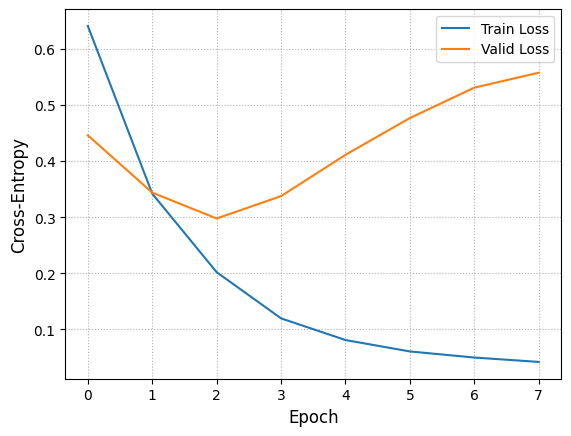

In [20]:
train_loss = history.history["loss"]
valid_loss = history.history["val_loss"]

fig, ax = plt.subplots(1, 1)
ax.plot(train_loss, label="Train Loss")
ax.plot(valid_loss, label="Valid Loss")
ax.grid(linestyle=":")
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Cross-Entropy", fontsize=12)
ax.legend()

In [21]:
# load best model

model.load_weights(ckpt_path)

In [22]:
# train loss / accuracy

model.evaluate(X_train, y_train)

586/586 [==============================] - 8s 13ms/step - loss: 0.1224 - accuracy: 0.9604


[0.1223575547337532, 0.9604266881942749]

In [23]:
# valid loss / accuracy

model.evaluate(X_valid, y_valid)

196/196 [==============================] - 3s 13ms/step - loss: 0.2976 - accuracy: 0.8829


[0.29760241508483887, 0.8828799724578857]

In [24]:
# test loss / accuracy

model.evaluate(X_test, y_test)

782/782 [==============================] - 10s 12ms/step - loss: 0.3394 - accuracy: 0.8674


[0.3393910229206085, 0.8673999905586243]